In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! pip install pydub speechbrain
! unzip /content/drive/MyDrive/Cust_utt/clipped_utterances.zip

In [ ]:
import glob, os

In [ ]:
glob.glob('/content/customer_utterances/*')[0]

In [ ]:
for i in glob.glob('/content/customer_utterances/*'):
    os.rename(i, i.split('.mp3')[0]+'_customer.wav')

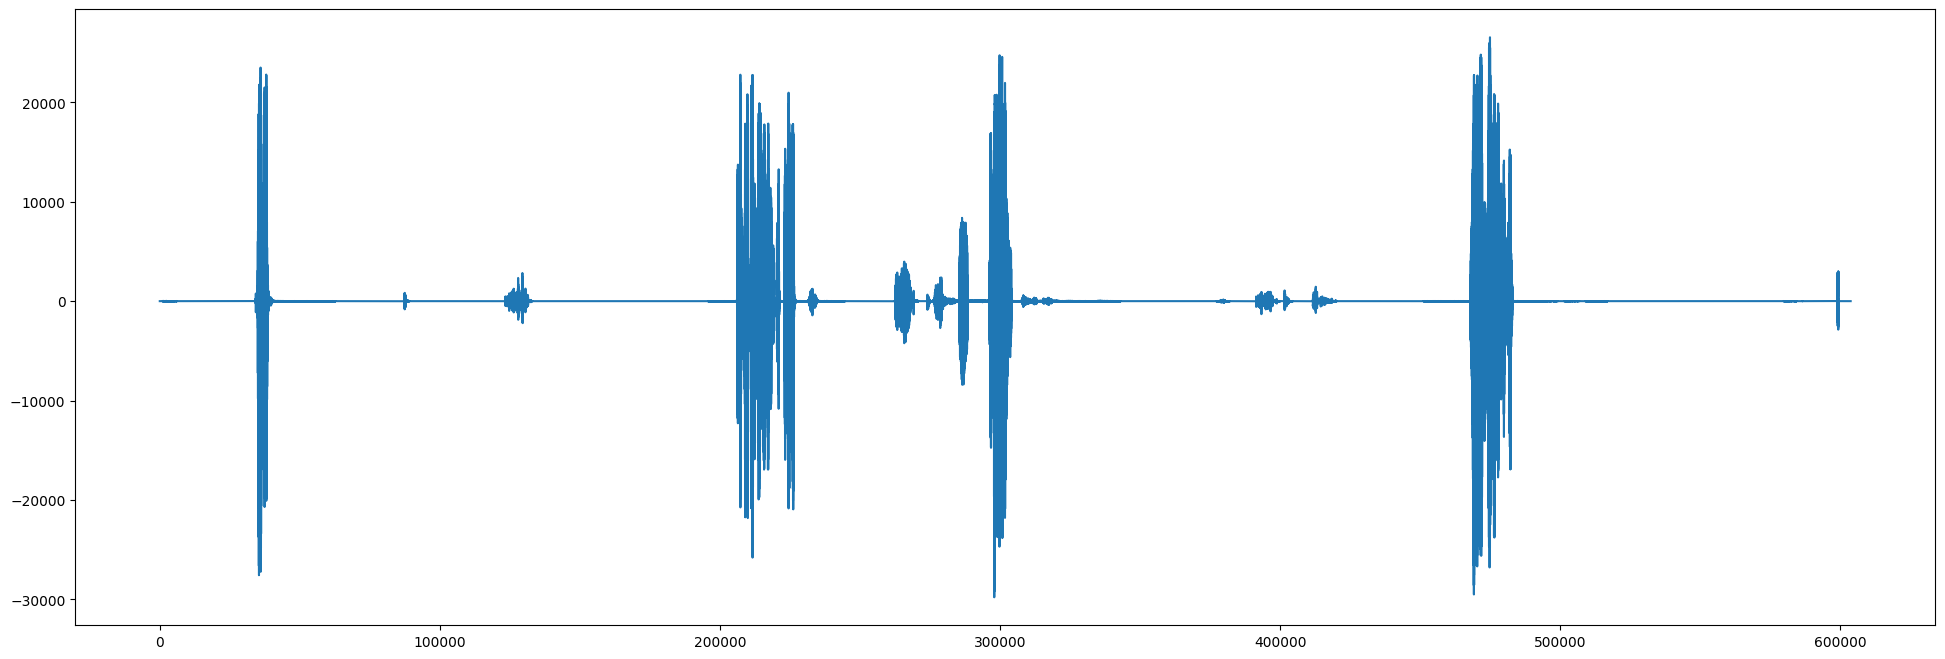

In [ ]:
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt

sound_file = glob.glob('/content/customer_utterances/*')[100]
rate, data = wf.read(sound_file)

plt.figure(figsize=(24,8))
plt.plot(data)
plt.show()

In [ ]:
from IPython.display import Audio, display

display(Audio(sound_file, autoplay=True))

In [ ]:
from pydub import AudioSegment
from pydub.silence import split_on_silence

In [ ]:
sound = AudioSegment.from_file(sound_file, format = 'wav')
audio_chunks = split_on_silence(sound
                            ,min_silence_len = 100
                            ,silence_thresh = -45
                            ,keep_silence = 50
                        )

combined = AudioSegment.empty()
for chunk in audio_chunks:
    combined += chunk

In [ ]:
combined.export('./test.wav', format = 'wav')

<_io.BufferedRandom name='./test.wav'>

In [ ]:
display(Audio('./test.wav', autoplay=True))

In [ ]:
! mkdir ./clipped_utterances

In [ ]:
sound_file.split('/')[-1]

'5c3ad465-1a0e-4a41-a596-c8db4a55de9a_customer.wav'

In [ ]:
save_path='./clipped_utterances/'

for i in glob.glob('/content/customer_utterances/*'):
    sound = AudioSegment.from_file(i, format = 'wav')
    audio_chunks = split_on_silence(sound
                                ,min_silence_len = 100
                                ,silence_thresh = -45
                                ,keep_silence = 50
                            )

    combined = AudioSegment.empty()
    for chunk in audio_chunks:
        combined += chunk
    combined.export('{0}{1}'.format(save_path, i.split('/')[-1]), format = 'wav')

In [ ]:
! ls ./customer_utterances | wc -l

1944


In [ ]:
! zip -r clipped_utterances.zip clipped_utterances/

In [ ]:
! rm *.wav

In [ ]:
for i in glob.glob('/content/customer_utterances/*'):
    os.rename(i, i.split('.mp3')[0]+'_customer.wav')

In [ ]:
! pip install azure.cognitiveservices.speech

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 27.2 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv('dataset.csv')
all_lang_list = list(Counter(df[df.columns[2]]).keys())
print(all_lang_list)
chosen_lang_list = all_lang_list[-3:-5:-1]+[all_lang_list[1]]
print(chosen_lang_list)

['Tamil', 'Marathi', 'Telugu', 'Kannada', 'Gujarati', 'Hindi', 'English', 'Malayalam']
['Hindi', 'Gujarati', 'Marathi']


In [ ]:
import azure.cognitiveservices.speech as speechsdk
# from speechbrain.pretrained import EncoderClassifier


def speech_language_detection_once_from_file(path):
    
    # Change dict and language list as required
    langID_to_Int={"hi-in":0, "gu-in":1, "mr-in":2}

    auto_detect_source_language_config = speechsdk.languageconfig.AutoDetectSourceLanguageConfig(languages = list(langID_to_Int.keys()))


    speech_config = speechsdk.SpeechConfig(subscription=SPEECH_KEY, region=SERVICE_REGION)
    audio_config = speechsdk.AudioConfig(filename=path)

    speech_config.enable_audio_logging()
    speech_config.set_property(
        property_id=speechsdk.PropertyId.SpeechServiceConnection_LanguageIdMode, value='Latency')
    speech_language_detection = speechsdk.SourceLanguageRecognizer(
        speech_config=speech_config, audio_config=audio_config, auto_detect_source_language_config=auto_detect_source_language_config)

    result = speech_language_detection.recognize_once()

    # Check the result. If recognized: appropriate language label. If not recognized: label - 4.
    if result.reason == speechsdk.ResultReason.RecognizedSpeech:
        detected_src_lang = result.properties[
            speechsdk.PropertyId.SpeechServiceConnection_AutoDetectSourceLanguageResult]
        return langID_to_Int[detected_src_lang]
    elif result.reason == speechsdk.ResultReason.NoMatch or result.reason == speechsdk.ResultReason.Canceled:
        return 4

# language_id = EncoderClassifier.from_hparams(source="sahita/language-identification", savedir="tmp", run_opts={"device":"cuda"})

def huggingface_LID_model(path):

    langID_to_Int={"en":0, "hi":1, "other":3}
    signal = language_id.load_audio(path)
    prediction =  language_id.classify_batch(signal)
    return langID_to_Int[prediction[3][0]]

In [ ]:
import glob
import subprocess
import pandas as pd
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import time

def data_loading(path_to_df):

    # Load and clean dataset
    print('Loading Dataset....')
    df = pd.read_csv(path_to_df)
    df.dropna(inplace = True)
    df.reset_index(drop = True, inplace = True)

    return df

def pruned_dataframe(df):

    # Choose 4 most abundant languages
    print('Pruning DataFrame....')
    lang_dict = Counter(df['information.language'])
    sorted_by_counts = list(sorted(lang_dict.items(), key = lambda x: x[1], reverse = True))
    top_4_lang = [ i[0] for i in sorted_by_counts ][:4]
    chosen_lang_list = ['Hindi', 'Gujarati', 'Marathi']

    # Eliminate other languages and eliminate unwanted features
    sub_df=pd.DataFrame(columns=['id', 'language', 'identified'])
    idx=0   # Index for sub_df

    # Select ID, language from original df and assign identified language as None
    for i in range(len(df)):
        if df.loc[i]['information.language'] in chosen_lang_list:
            sub_df.loc[idx]=[df.loc[i]['information.sessionId'], df.loc[i]['information.language'], None]
            idx+=1

    return sub_df

In [ ]:
def make_predictions(model_id, utter_dir, sub_df):
    
    model = {0: speech_language_detection_once_from_file, 1: huggingface_LID_model}
    res_file = {0: 'results_azure.csv', 1: 'results_hf.csv'}
    print('Making Predictions....')
    
    count_not_ided = 0
    t1 = time.perf_counter()
    
    for i in range(len(sub_df)):
        if not i % 100: print('Sample {}'.format(i))
        path=os.path.join(utter_dir, sub_df.loc[i]['id'])+'_customer.wav'
        try:
            sub_df.loc[i]['identified']=model[model_id](path)
        except :
            sub_df.loc[i]['identified']=4   # couldn't identify due to exceptions
            count_not_ided += 1
    
    t2 = time.perf_counter()
    
    total = len(sub_df)-count_not_ided
    print('Time taken for evaluation of {} samples is {:.2f} seconds.\nLatency is: {:.2f}'.format(total, t2-t1, ((t2-t1)/total)))
    
    # if model_id: runcmd('rm *.wav') # Model creates copies of wav files in the pwd which must be deleted
    
    # Convert Languages to IDs
    label_to_Int = {'English':0, 'Hindi':1, 'Tamil':3, 'Kannada':3} if model_id else {'Hindi':0, 'Gujarati':1, 'Marathi':2}   # make changes if newer models are added
    for i in range(len(sub_df)):
        sub_df.loc[i]['language']=label_to_Int[sub_df.loc[i]['language']]
        
    # Save results
    sub_df.to_csv(res_file[model_id])

In [ ]:
def evaluate(model_id):
    
    res_file = {0: 'results_azure_hi-gu-mr.csv', 1: 'results_hf.csv'}
    sub_df = pd.read_csv(res_file[model_id])
    
    yhat = sub_df['identified']
    y = sub_df['language']
    
    # Unrecognized Percentage
    res_count_dict = Counter(yhat)
    try:
        print('Percent unrecognized: {:.2f}'.format(res_count_dict[4]/sum(res_count_dict.values())*100))
    except ZeroDivisionError as e:
        print(e)
        pass

    # Accuracy including Not Identified
    correct_not_det=0
    for i in range(len(yhat)):
        if yhat[i] == y[i]:
            correct_not_det += 1

    print('Accuracy including not identified: {:.2f}'.format(correct_not_det/len(y)*100))

    # Remove not identified from sub_df
    sub_df_det = sub_df[sub_df.identified != 4]
    sub_df_det.reset_index(drop=True, inplace=True)

    # Accuracy excluding Not Identified
    correct_det = 0
    for i in range(len(sub_df_det)):
        if sub_df_det.identified[i]==sub_df_det.language[i]:
            correct_det+=1

    try:
        print('Accuracy excluding not identified: {:.2f}'.format(correct_det/len(sub_df_det)*100))
    except ZeroDivisionError as e:
        print(e, 'Variable sub_df_det: {} may be empty'.format(sub_df_det), sep='\n')
        pass
    
    print('Balanced Accuracy Score: {:.2f}'.format(balanced_accuracy_score(sub_df_det.language, sub_df_det.identified)*100))

    # Confusion Matrix
    if model_id:
        cm = confusion_matrix(y, yhat, labels=[0,1,3,4])
        cm_df = pd.DataFrame(cm, index = ['English','Hindi','Other', 'None'],
            columns = ['English','Hindi','Other', 'None'])
    else:
        cm = confusion_matrix(y, yhat, labels=[0,1,2,4])
        cm_df = pd.DataFrame(cm, index = ['Hindi', 'Gujarati', 'Marathi', 'None'],
                columns = ['Hindi', 'Gujarati', 'Marathi', 'None'])
    print(cm_df)

    # # Plot as Heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()


### Clipped

Loading Dataset....
Pruning DataFrame....
Percent unrecognized: 4.58
Accuracy including not identified: 80.89
Accuracy excluding not identified: 84.77
Balanced Accuracy Score: 71.32
          Hindi  Gujarati  Marathi  None
Hindi       559         8       27    37
Gujarati     54        46        8     1
Marathi      30         0      102     2
None          0         0        0     0


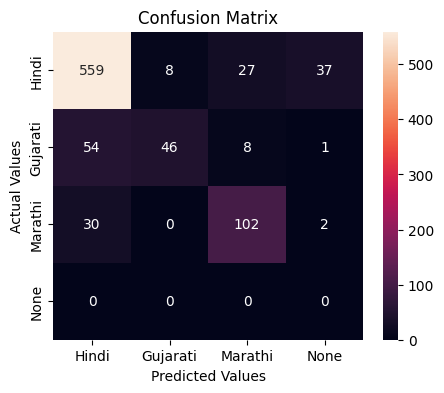

In [ ]:
path = './dataset.csv'
# audio_dir = './audios'
utterance_dir = './clipped_utterances'
df = data_loading(path)
sub_df = pruned_dataframe(df)
# download_recordings(df, audio_dir, utterance_dir)
model_id = 0
# make_predictions(model_id, utterance_dir, sub_df)
evaluate(model_id)

### Unclipped

In [ ]:
path = './dataset.csv'
# audio_dir = './audios'
utterance_dir = './customer_utterances'
df = data_loading(path)
sub_df = pruned_dataframe(df)
# download_recordings(df, audio_dir, utterance_dir)
model_id = 1
make_predictions(model_id, utterance_dir, sub_df)
evaluate(model_id)

In [ ]:
test_df = pd.read_csv('results_azure_hi-gu-mr.csv')
test_df = test_df.drop(test_df[test_df.identified==4].index)
y = test_df.language
yhat = test_df.identified
balanced_accuracy_score(y, yhat)

0.7132435465768799

In [ ]:
guj = test_df.drop(test_df[test_df.language!=1].index)

In [ ]:
guj

,Unnamed: 0,id,language,identified
10,10,79342e4c-f69c-469a-9de0-0e0c58cd42ab,1,0
11,11,4ed8f491-c3bb-4677-a43d-2bdfe25074e4,1,0
12,12,4ce5ad1b-9dc4-4e7f-b0af-0683cd61fde1,1,0
13,13,ad461791-b555-45fd-aec3-380a1b5af748,1,1
14,14,99f10e93-39d0-46ce-bf5f-08b642ca1681,1,1
...,...,...,...,...
253,253,1bd9743e-4880-4736-bed9-4e43d52096f0,1,0
254,254,2508fa48-bc34-4da5-8266-eeddd83ccd19,1,0
256,256,d3d38911-ff61-4de2-afc6-b0de3810d537,1,1
258,258,336960b4-4232-46bf-942d-15845f02553b,1,0


In [ ]:
id='2508fa48-bc34-4da5-8266-eeddd83ccd19'
path=f'clipped_utterances/{id}_customer.wav'

In [ ]:
from IPython.display import Audio, display

display(Audio(path, autoplay=True))

### LID from byte streams 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! pip install azure.cognitiveservices.speech
! pip  install pydub
import azure.cognitiveservices.speech as speechsdk
import wave
import json
import time
from pydub import AudioSegment


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! unzip /content/drive/MyDrive/Cust_utt/clipped_utterances.zip

In [ ]:
def speech_language_detection_once_from_file(path):
    
    # Change dict and language list as required
    langID_to_Int={"hi-IN":0, "ta-IN":1, "gu-IN":2, "en-in":3}

    auto_detect_source_language_config = speechsdk.languageconfig.AutoDetectSourceLanguageConfig(languages = list(langID_to_Int.keys()))


    speech_config = speechsdk.SpeechConfig(subscription=SPEECH_KEY, region=SERVICE_REGION)
    audio_config = speechsdk.AudioConfig(filename=path)

    speech_config.enable_audio_logging()
    speech_config.set_property(
        property_id=speechsdk.PropertyId.SpeechServiceConnection_LanguageIdMode, value='Latency')
    speech_language_detection = speechsdk.SourceLanguageRecognizer(
        speech_config=speech_config, audio_config=audio_config, auto_detect_source_language_config=auto_detect_source_language_config)

    result = speech_language_detection.recognize_once()

    # Check the result. If recognized: appropriate language label. If not recognized: label - 4.
    if result.reason == speechsdk.ResultReason.RecognizedSpeech:
        detected_src_lang = result.properties[
            speechsdk.PropertyId.SpeechServiceConnection_AutoDetectSourceLanguageResult]
        return langID_to_Int[detected_src_lang]
    elif result.reason == speechsdk.ResultReason.NoMatch or result.reason == speechsdk.ResultReason.Canceled:
        return 4

In [ ]:
path = '/content/clipped_utterances/01464bb3-380e-494a-bd89-ede7697662c2_customer.wav'

In [ ]:
speech_language_detection_once_from_file(path)

3

In [ ]:
def push_stream_writer(stream, file_path):
    # The number of bytes to push per buffer
    split = AudioSegment.from_wav(file_path)
    # split = split[:750]
    stream.write(split.raw_data)
    stream.close()

def bytestream_LID_cont(file_path):
    """performs continuous speech language detection with input from an audio file"""
    
    langID_to_Int={"hi-IN":0, "ta-IN":1, "gu-IN":2, "en-IN":3}
    # <SpeechContinuousLanguageDetectionWithFile>
    # Creates an AutoDetectSourceLanguageConfig, which defines a number of possible spoken languages
    auto_detect_source_language_config = \
        speechsdk.languageconfig.AutoDetectSourceLanguageConfig(languages=list(langID_to_Int.keys()))

    # Creates a SpeechConfig from your speech key and region
    speech_config = speechsdk.SpeechConfig(subscription=SPEECH_KEY, region=SERVICE_REGION)

    # Set continuous language detection (override the default of "AtStart")
    speech_config.set_property(
        property_id=speechsdk.PropertyId.SpeechServiceConnection_LanguageIdMode, value='Continuous')

    stream = speechsdk.audio.PushAudioInputStream()
    audio_config = speechsdk.audio.AudioConfig(stream=stream)

    source_language_recognizer = speechsdk.SourceLanguageRecognizer(
        speech_config=speech_config,
        auto_detect_source_language_config=auto_detect_source_language_config,
        audio_config=audio_config)

    done = False

    def stop_cb(evt: speechsdk.SessionEventArgs):
        """callback that signals to stop continuous recognition upon receiving an event `evt`"""
        print('CLOSING on {}'.format(evt))
        nonlocal done
        done = True

    def audio_recognized(evt: speechsdk.SpeechRecognitionEventArgs):
        """
        callback that catches the recognized result of audio from an event 'evt'.
        :param evt: event listened to catch recognition result.
        :return:
        """
        if evt.result.reason == speechsdk.ResultReason.RecognizedSpeech:
            if evt.result.properties.get(
                    speechsdk.PropertyId.SpeechServiceConnection_AutoDetectSourceLanguageResult) is None:
                print("Unable to detect any language")
            else:
                detected_src_lang = evt.result.properties[
                    speechsdk.PropertyId.SpeechServiceConnection_AutoDetectSourceLanguageResult]
                json_result = evt.result.properties[speechsdk.PropertyId.SpeechServiceResponse_JsonResult]
                detail_result = json.loads(json_result)
                start_offset = detail_result['Offset']
                duration = detail_result['Duration']
                if duration >= 0:
                    end_offset = duration + start_offset
                else:
                    end_offset = 0
                print("Detected language = " + detected_src_lang)
                print(f"Start offset = {start_offset}, End offset = {end_offset}, "
                      f"Duration = {duration} (in units of hundreds of nanoseconds (HNS))")
                global language_detected
                language_detected = True

    # Connect callbacks to the events fired by the speech recognizer
    source_language_recognizer.recognized.connect(audio_recognized)
    source_language_recognizer.session_started.connect(lambda evt: print('SESSION STARTED: {}'.format(evt)))
    source_language_recognizer.session_stopped.connect(lambda evt: print('SESSION STOPPED {}'.format(evt)))
    source_language_recognizer.canceled.connect(lambda evt: print('CANCELED {}'.format(evt)))
    # stop continuous recognition on either session stopped or canceled events
    source_language_recognizer.session_stopped.connect(stop_cb)
    source_language_recognizer.canceled.connect(stop_cb)

    push_stream_writer(stream, file_path)

    # Start continuous speech recognition
    source_language_recognizer.start_continuous_recognition()
    while not done:
        time.sleep(.5)

    source_language_recognizer.stop_continuous_recognition()
    # </SpeechContinuousLanguageDetectionWithFile>

#### Experimenting With Code

In [ ]:

def push_stream_writer_test(stream, file_path):
    # The number of bytes to push per buffer
    split = AudioSegment.from_wav(file_path)
    # split = split[:750]
    stream.write(split.raw_data)
    stream.close()

def bytestream_LID_oneshot_test(file_path):
    """performs continuous speech language detection with input from an audio file"""
    
    langID_to_Int={"hi-in":0, "ta-in":1, "mr-in":2, "en-in":3}
    # <SpeechContinuousLanguageDetectionWithFile>
    # Creates an AutoDetectSourceLanguageConfig, which defines a number of possible spoken languages
    auto_detect_source_language_config = \
        speechsdk.languageconfig.AutoDetectSourceLanguageConfig(languages=list(langID_to_Int.keys()))

    # Creates a SpeechConfig from your speech key and region
    speech_config = speechsdk.SpeechConfig(subscription=SPEECH_KEY, region=SERVICE_REGION)

    # Set continuous language detection (override the default of "AtStart")
    speech_config.set_property(
        property_id=speechsdk.PropertyId.SpeechServiceConnection_LanguageIdMode, value='Continuous')

    stream = speechsdk.audio.PushAudioInputStream()
    push_stream_writer(stream, file_path)
    audio_config = speechsdk.audio.AudioConfig(stream=stream)

    source_language_recognizer = speechsdk.SourceLanguageRecognizer(
        speech_config=speech_config,
        auto_detect_source_language_config=auto_detect_source_language_config,
        audio_config=audio_config)

    result = source_language_recognizer.recognize_once()

    # Check the result. If recognized: appropriate language label. If not recognized: label - 4.
    if result.reason == speechsdk.ResultReason.RecognizedSpeech:
        detected_src_lang = result.properties[
            speechsdk.PropertyId.SpeechServiceConnection_AutoDetectSourceLanguageResult]
        return langID_to_Int[detected_src_lang]
    elif result.reason == speechsdk.ResultReason.NoMatch or result.reason == speechsdk.ResultReason.Canceled:
        return 4

In [ ]:
bytestream_LID_oneshot_test(path)

1

In [ ]:
t1 = 0
t2 = 200
split = AudioSegment.from_wav(path)
split = split[t1:t2]
stream = split.raw_data
print(len(stream))

3200


In [ ]:
len(split)

3486

In [ ]:
! ffprobe -show_entries format=duration -i /content/clipped_utterances/01464bb3-380e-494a-bd89-ede7697662c2_customer.wav

ffprobe version 4.2.7-0ubuntu0.1 Copyright (c) 2007-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('dataset.csv')
english_ids= list(df.groupby('information.language', group_keys=False).apply(lambda x: x.sample(5))[df['information.language'] == 'English']['information.sessionId'])
hindi_ids= list(df.groupby('information.language', group_keys=False).apply(lambda x: x.sample(5))[df['information.language'] == 'Hindi']['information.sessionId'])
marathi_ids= list(df.groupby('information.language', group_keys=False).apply(lambda x: x.sample(5))[df['information.language'] == 'Marathi']['information.sessionId'])
tamil_ids= list(df.groupby('information.language', group_keys=False).apply(lambda x: x.sample(5))[df['information.language'] == 'Tamil']['information.sessionId'])

In [ ]:
def push_stream_writer(stream, file_path, i, j):
    # The number of bytes to push per buffer
    split = AudioSegment.from_wav(file_path)
    split = split[i:j]
    stream.write(split.raw_data)
    stream.close()

def bytestream_LID_oneshot(file_path, i, j):
    """performs continuous speech language detection with input from an audio file"""
    
    langID_to_Int={"hi-in":0, "ta-in":1, "mr-in":2, "en-in":3, 'unknown':4}
    # <SpeechContinuousLanguageDetectionWithFile>
    # Creates an AutoDetectSourceLanguageConfig, which defines a number of possible spoken languages
    auto_detect_source_language_config = \
        speechsdk.languageconfig.AutoDetectSourceLanguageConfig(languages=list(langID_to_Int.keys())[:-1])

    # Creates a SpeechConfig from your speech key and region
    speech_config = speechsdk.SpeechConfig(subscription=SPEECH_KEY, region=SERVICE_REGION)

    # Set continuous language detection (override the default of "AtStart")
    speech_config.set_property(
        property_id=speechsdk.PropertyId.SpeechServiceConnection_LanguageIdMode, value='Continuous')

    stream = speechsdk.audio.PushAudioInputStream()
    push_stream_writer(stream, file_path, i, j)
    audio_config = speechsdk.audio.AudioConfig(stream=stream)

    source_language_recognizer = speechsdk.SourceLanguageRecognizer(
        speech_config=speech_config,
        auto_detect_source_language_config=auto_detect_source_language_config,
        audio_config=audio_config)

    result = source_language_recognizer.recognize_once()

    # Check the result. If recognized: appropriate language label. If not recognized: label - 4.
    if result.reason == speechsdk.ResultReason.RecognizedSpeech:
        detected_src_lang = result.properties[
            speechsdk.PropertyId.SpeechServiceConnection_AutoDetectSourceLanguageResult]
        return langID_to_Int[detected_src_lang]
    elif result.reason == speechsdk.ResultReason.NoMatch or result.reason == speechsdk.ResultReason.Canceled:
        return 4

#### English: 3

In [ ]:
english_ids, hindi_ids, marathi_ids, tamil_ids

(['cf32e8c7-6d87-4fd3-8401-a27c9b1bd16e',
  '2d0fa0ac-3b20-4dc6-b33f-7a767ec3c03e',
  'a914693d-795d-4f10-b050-de91958b4b25',
  'be7c45bb-decb-4ae0-b942-47f77a115dce',
  'de643534-2b48-4f85-aeaf-a0aa039b64f6'],
 ['3488a0e0-0c10-4d48-9f37-deedff906e58',
  '0ea3a7dd-4ada-4ed5-995d-c40fb4f731e4',
  '01701461-1c28-4a65-9b90-1a4301a90d30',
  '5bf65b8e-ef3b-4e25-b279-9dec6f827a9d',
  '3ce72252-0a28-42a1-b64e-3a7a9695e186'],
 ['cb9dd219-abc0-48c8-9b3e-69b5d8abae20',
  '10c0f925-45d3-4c8f-9536-8eefd8f77190',
  '2048326b-f72c-41e6-8cdc-1c8fdd18f84b',
  'd3462cb0-e42d-44a7-88c3-93c53ab95e07',
  '6cec8142-531a-4b3f-b888-73d4800b9766'],
 ['b6190985-085c-41d1-bbe6-3447d0c2d4ea',
  '9b6c83af-ad81-47fe-b2a1-47263d70dde5',
  'b6ed4b98-4f00-4a4d-b816-111f17858ba2',
  '3a0d3f36-78df-4004-a0a6-96969dd5ebd6',
  'd289226b-e2c5-46e0-828c-f5b2f1aaec1e'])

In [ ]:
from collections import Counter, defaultdict

In [ ]:
english_perf=defaultdict(dict)

In [ ]:
for i in enumerate(english_ids):
    print(f'\nFile {i[0]+1} {i[1]} .....')
    for j in range(500, 1600, 50):
        print(f'\n\tBit Length {j} ....')
        path = './clipped_utterances/'+i[1]+'_customer.wav'
        audio_len = len(AudioSegment.from_wav(path))
        ls=[]
        for k in range(audio_len//j):
            print(f'\t\tSegment {k} ....', end='\t')
            x, y = k*j, (k+1)*j
            ls.append(bytestream_LID_oneshot(path, x, y))
        english_perf[j] = Counter(ls)


File 1 cf32e8c7-6d87-4fd3-8401-a27c9b1bd16e .....

	Bit Length 500 ....
		Segment 0 ....			Segment 1 ....			Segment 2 ....			Segment 3 ....			Segment 4 ....			Segment 5 ....			Segment 6 ....			Segment 7 ....	
	Bit Length 550 ....
		Segment 0 ....			Segment 1 ....			Segment 2 ....			Segment 3 ....			Segment 4 ....			Segment 5 ....			Segment 6 ....			Segment 7 ....	
	Bit Length 600 ....
		Segment 0 ....			Segment 1 ....			Segment 2 ....			Segment 3 ....			Segment 4 ....			Segment 5 ....			Segment 6 ....	
	Bit Length 650 ....
		Segment 0 ....			Segment 1 ....			Segment 2 ....			Segment 3 ....			Segment 4 ....			Segment 5 ....	
	Bit Length 700 ....
		Segment 0 ....			Segment 1 ....			Segment 2 ....			Segment 3 ....			Segment 4 ....			Segment 5 ....	
	Bit Length 750 ....
		Segment 0 ....			Segment 1 ....			Segment 2 ....			Segment 3 ....			Segment 4 ....	
	Bit Length 800 ....
		Segment 0 ....			Segment 1 ....			Segment 2 ....			Segment 3 ....			Segment 4 ....	
	Bit Length 850 ....
		Segmen

In [ ]:
english_perf

defaultdict(dict,
            {500: Counter({4: 18}),
             550: Counter({2: 14, 1: 1, 3: 1}),
             600: Counter({2: 11, 0: 4}),
             650: Counter({0: 6, 2: 6, 1: 1}),
             700: Counter({2: 4, 0: 5, 1: 3}),
             750: Counter({2: 6, 1: 4, 0: 2}),
             800: Counter({0: 5, 2: 5, 1: 1}),
             850: Counter({0: 7, 1: 2, 2: 1}),
             900: Counter({0: 5, 2: 2, 1: 3}),
             950: Counter({0: 3, 2: 4, 1: 1, 3: 1}),
             1000: Counter({0: 2, 2: 6, 3: 1}),
             1050: Counter({0: 2, 2: 4, 3: 2}),
             1100: Counter({3: 5, 2: 2, 1: 1}),
             1150: Counter({3: 3, 2: 1, 0: 2, 1: 1}),
             1200: Counter({2: 3, 0: 3, 3: 1}),
             1250: Counter({3: 4, 0: 2, 2: 1}),
             1300: Counter({3: 4, 2: 2}),
             1350: Counter({3: 6}),
             1400: Counter({3: 4, 0: 1, 2: 1}),
             1450: Counter({3: 5, 0: 1}),
             1500: Counter({3: 4, 0: 1, 2: 1}),
           

In [ ]:
key=3
y=[]
x=np.asarray(list(english_perf.keys()))
for val in english_perf.values():
    acc = val[key]/sum(val.values())
    y.append(acc*100)
y=np.asarray(y)

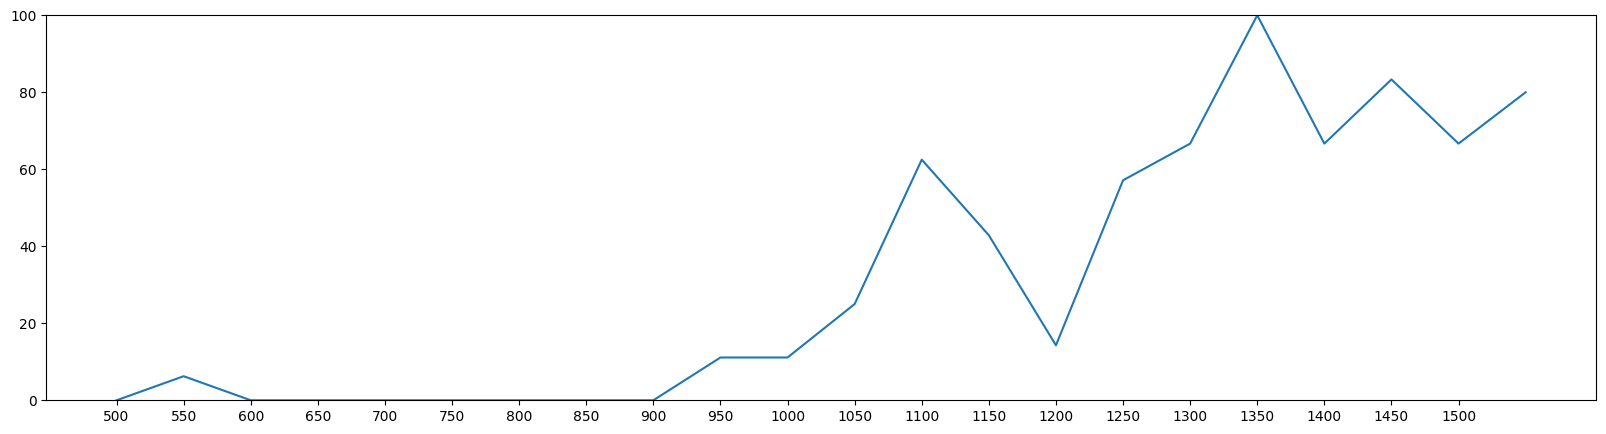

In [ ]:
plt.figure(figsize=(20,5))
plt.ylim([0,100])
plt.xticks(np.arange(500, 1550, 50))
plt.plot(x,y)

#### Hindi: 0

In [ ]:
hindi_perf=defaultdict(dict)
hindi_ids[0]='c22bbdda-e3b3-413b-a0d2-29abcc0c6bea'

In [ ]:
for i in enumerate(hindi_ids):
    print(f'\nFile {i[0]+1} {i[1]} .....')
    for j in range(500, 1600, 50):
        print(f'\n\tBit Length {j} ....')
        path = './clipped_utterances/'+i[1]+'_customer.wav'
        audio_len = len(AudioSegment.from_wav(path))
        ls=[]
        for k in range(audio_len//j):
            print(f'\t\tSegment {k} ....', end='\t')
            x, y = k*j, (k+1)*j
            ls.append(bytestream_LID_oneshot(path, x, y))
        hindi_perf[j] = Counter(ls)


File 1 c22bbdda-e3b3-413b-a0d2-29abcc0c6bea .....

	Bit Length 500 ....
		Segment 0 ....			Segment 1 ....			Segment 2 ....			Segment 3 ....			Segment 4 ....			Segment 5 ....			Segment 6 ....			Segment 7 ....			Segment 8 ....			Segment 9 ....			Segment 10 ....			Segment 11 ....			Segment 12 ....			Segment 13 ....			Segment 14 ....			Segment 15 ....			Segment 16 ....			Segment 17 ....			Segment 18 ....			Segment 19 ....			Segment 20 ....			Segment 21 ....			Segment 22 ....			Segment 23 ....			Segment 24 ....			Segment 25 ....			Segment 26 ....			Segment 27 ....			Segment 28 ....			Segment 29 ....			Segment 30 ....			Segment 31 ....			Segment 32 ....			Segment 33 ....			Segment 34 ....			Segment 35 ....			Segment 36 ....			Segment 37 ....			Segment 38 ....			Segment 39 ....			Segment 40 ....			Segment 41 ....	
	Bit Length 550 ....
		Segment 0 ....			Segment 1 ....			Segment 2 ....			Segment 3 ....			Segment 4 ....			Segment 5 ....			Segment 6 ....			Segment 7 ....			Segment 8 ....			Segm

In [ ]:
hindi_perf

defaultdict(dict,
            {500: Counter({4: 24}),
             550: Counter({2: 15, 1: 1, 3: 1, 0: 5}),
             600: Counter({2: 14, 0: 5, 1: 1}),
             650: Counter({2: 8, 0: 9, 1: 1}),
             700: Counter({2: 8, 0: 7, 1: 2}),
             750: Counter({2: 9, 0: 4, 1: 3}),
             800: Counter({0: 7, 2: 6, 1: 2}),
             850: Counter({0: 8, 2: 6}),
             900: Counter({0: 6, 1: 4, 2: 3}),
             950: Counter({1: 2, 0: 6, 2: 2, 3: 2}),
             1000: Counter({1: 4, 0: 4, 2: 3, 3: 1}),
             1050: Counter({1: 4, 0: 5, 2: 2}),
             1100: Counter({3: 4, 0: 3, 2: 4}),
             1150: Counter({3: 6, 0: 2, 1: 1, 2: 1}),
             1200: Counter({3: 7, 2: 1, 0: 1, 1: 1}),
             1250: Counter({0: 1, 3: 6, 1: 2}),
             1300: Counter({0: 4, 3: 5}),
             1350: Counter({0: 2, 3: 7}),
             1400: Counter({0: 3, 3: 4, 1: 1}),
             1450: Counter({3: 4, 0: 2, 2: 2}),
             1500: Counter({3

In [ ]:
key=0
y=[]
x=np.asarray(list(hindi_perf.keys()))
for val in hindi_perf.values():
    acc = val[key]/sum(val.values())
    y.append(acc*100)
y=np.asarray(y)

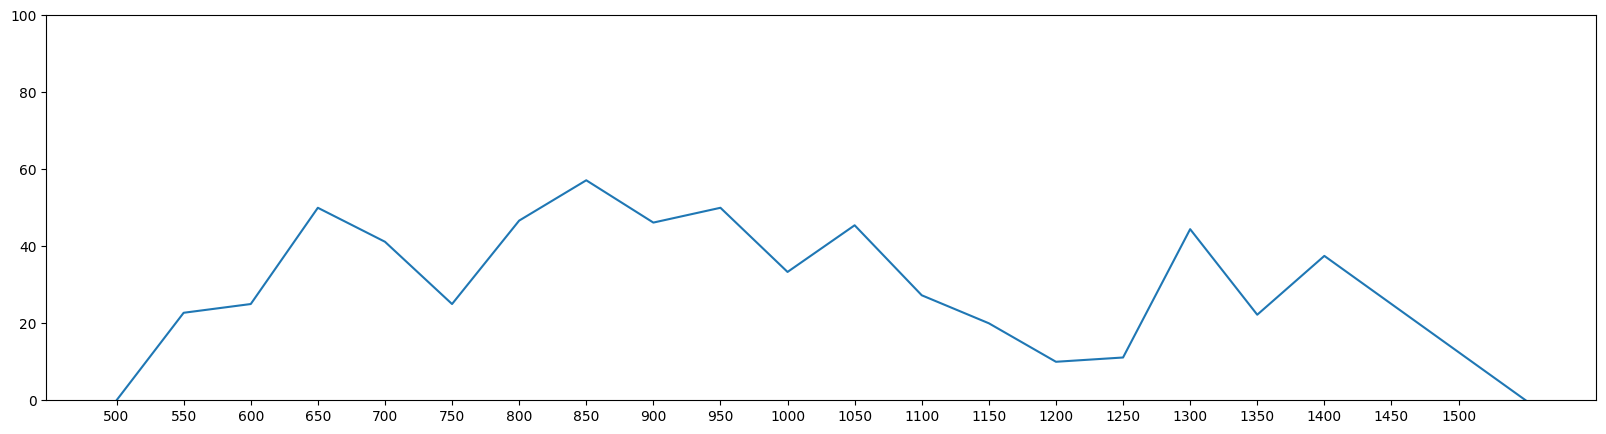

In [ ]:
plt.figure(figsize=(20,5))
plt.ylim([0,100])
plt.xticks(np.arange(500, 1550, 50))
plt.plot(x,y)

In [ ]:
for j in range(500, 1600, 50):
    print(f'\n\tBit Length {j} ....')
    path = './clipped_utterances/'+hindi_ids[0]+'_customer.wav'
    audio_len = len(AudioSegment.from_wav(path))
    ls=[]
    for k in range(audio_len//j):
        print(f'\t\tSegment {k} ....', end='\t')
        x, y = k*j, (k+1)*j
        ans = bytestream_LID_oneshot(path, x, y)
        print(ans, end='\t')
        ls.append(ans)

In [ ]:
ls

[2, 2, 1, 3, 1, 1, 0, 1, 3, 2, 1, 1, 2]

In [ ]:
path = './clipped_utterances/194ff5d1-a412-4e91-9e96-d25ee5d6e8c6_customer.wav'
audio = AudioSegment.from_wav(path)
# k = len(split)//1200
i=1550*0
j=1550*1
split = audio[i:j]
# stream.write(split.raw_data)
# stream.close()
split

In [ ]:
langID_to_Int={"hi-in":0, "ta-in":1, "mr-in":2, "en-in":3, 'unknown':4}
# <SpeechContinuousLanguageDetectionWithFile>
# Creates an AutoDetectSourceLanguageConfig, which defines a number of possible spoken languages
auto_detect_source_language_config = \
    speechsdk.languageconfig.AutoDetectSourceLanguageConfig(languages=list(langID_to_Int.keys())[:-1])

# Creates a SpeechConfig from your speech key and region
speech_config = speechsdk.SpeechConfig(subscription=SPEECH_KEY, region=SERVICE_REGION)

# Set continuous language detection (override the default of "AtStart")
speech_config.set_property(
    property_id=speechsdk.PropertyId.SpeechServiceConnection_LanguageIdMode, value='Continuous')

stream = speechsdk.audio.PushAudioInputStream()
stream.write(split.raw_data)
stream.close()
audio_config = speechsdk.audio.AudioConfig(stream=stream)

source_language_recognizer = speechsdk.SourceLanguageRecognizer(
    speech_config=speech_config,
    auto_detect_source_language_config=auto_detect_source_language_config,
    audio_config=audio_config)

result = source_language_recognizer.recognize_once()

# Check the result. If recognized: appropriate language label. If not recognized: label - 4.
if result.reason == speechsdk.ResultReason.RecognizedSpeech:
    detected_src_lang = result.properties[
        speechsdk.PropertyId.SpeechServiceConnection_AutoDetectSourceLanguageResult]
    print(detected_src_lang)
elif result.reason == speechsdk.ResultReason.NoMatch or result.reason == speechsdk.ResultReason.Canceled:
    print('Error')

ta-in


In [ ]:
result.duration

7750000

#### Marathi: 2

In [ ]:
marathi_perf=defaultdict(dict)
marathi_ids[3]='aecb2d40-3f73-44cb-97c6-b3e1d494cf6d'

In [ ]:
for i in enumerate(marathi_ids):
    print(f'\nFile {i[0]+1} {i[1]} .....')
    for j in range(500, 1600, 50):
        print(f'\n\tBit Length {j} ....')
        path = './clipped_utterances/'+i[1]+'_customer.wav'
        audio_len = len(AudioSegment.from_wav(path))
        ls=[]
        for k in range(audio_len//j):
            print(f'\t\tSegment {k} ....', end='\t')
            x, y = k*j, (k+1)*j
            ls.append(bytestream_LID_oneshot(path, x, y))
        marathi_perf[j] = Counter(ls)

In [ ]:
marathi_perf

In [ ]:
key=2
y=[]
x=np.asarray(list(marathi_perf.keys()))
for val in marathi_perf.values():
    acc = val[key]/sum(val.values())
    y.append(acc*100)
y=np.asarray(y)

In [ ]:
plt.ylim([0,100])
plt.xticks(np.arange(500, 1550, 50))
plt.plot(x,y)

#### Tamil: 1

In [ ]:
tamil_perf=defaultdict(dict)

In [ ]:
for i in enumerate(tamil_ids):
    print(f'\nFile {i[0]+1} {i[1]} .....')
    for j in range(500, 1600, 50):
        print(f'\n\tBit Length {j} ....')
        path = './clipped_utterances/'+i[1]+'_customer.wav'
        audio_len = len(AudioSegment.from_wav(path))
        ls=[]
        for k in range(audio_len//j):
            print(f'\t\tSegment {k} ....', end='\t')
            x, y = k*j, (k+1)*j
            ls.append(bytestream_LID_oneshot(path, x, y))
        tamil_perf[j] = Counter(ls)

In [ ]:
tamil_perf

defaultdict(dict,
            {500: Counter({4: 16}),
             550: Counter({2: 14, 0: 1}),
             600: Counter({2: 11, 3: 2, 0: 1}),
             650: Counter({1: 1, 2: 11, 0: 1}),
             700: Counter({2: 7, 1: 2, 0: 3}),
             750: Counter({2: 7, 1: 2, 0: 2}),
             800: Counter({2: 5, 1: 3, 0: 2}),
             850: Counter({1: 3, 3: 2, 2: 4}),
             900: Counter({1: 3, 3: 3, 0: 1, 2: 2}),
             950: Counter({2: 4, 1: 2, 0: 2}),
             1000: Counter({2: 3, 3: 1, 1: 1, 0: 3}),
             1050: Counter({2: 5, 1: 3}),
             1100: Counter({2: 2, 1: 4, 3: 1}),
             1150: Counter({2: 2, 1: 4, 0: 1}),
             1200: Counter({1: 3, 2: 4}),
             1250: Counter({1: 3, 2: 3}),
             1300: Counter({1: 2, 2: 3, 3: 1}),
             1350: Counter({1: 3, 0: 1, 2: 2}),
             1400: Counter({1: 3, 2: 1, 3: 1, 0: 1}),
             1450: Counter({2: 3, 1: 1, 3: 1}),
             1500: Counter({2: 2, 1: 3}),
    

defaultdict(dict,
            {500: Counter({4: 16}),
             550: Counter({2: 14, 0: 1}),
             600: Counter({2: 11, 3: 2, 0: 1}),
             650: Counter({1: 1, 2: 11, 0: 1}),
             700: Counter({2: 7, 1: 2, 0: 3}),
             750: Counter({2: 7, 1: 2, 0: 2}),
             800: Counter({2: 5, 1: 3, 0: 2}),
             850: Counter({1: 3, 3: 2, 2: 4}),
             900: Counter({1: 3, 3: 3, 0: 1, 2: 2}),
             950: Counter({2: 4, 1: 2, 0: 2}),
             1000: Counter({2: 3, 3: 1, 1: 1, 0: 3}),
             1050: Counter({2: 5, 1: 3}),
             1100: Counter({2: 2, 1: 4, 3: 1}),
             1150: Counter({2: 2, 1: 4, 0: 1}),
             1200: Counter({1: 3, 2: 4}),
             1250: Counter({1: 3, 2: 3}),
             1300: Counter({1: 2, 2: 3, 3: 1}),
             1350: Counter({1: 3, 0: 1, 2: 2}),
             1400: Counter({1: 3, 2: 1, 3: 1, 0: 1}),
             1450: Counter({2: 3, 1: 1, 3: 1}),
             1500: Counter({2: 2, 1: 3}),
    

In [ ]:
key=1
y=[]
x=np.asarray(list(tamil_perf.keys()))
for val in tamil_perf.values():
    acc = val[key]/sum(val.values())
    y.append(acc*100)
y=np.asarray(y)

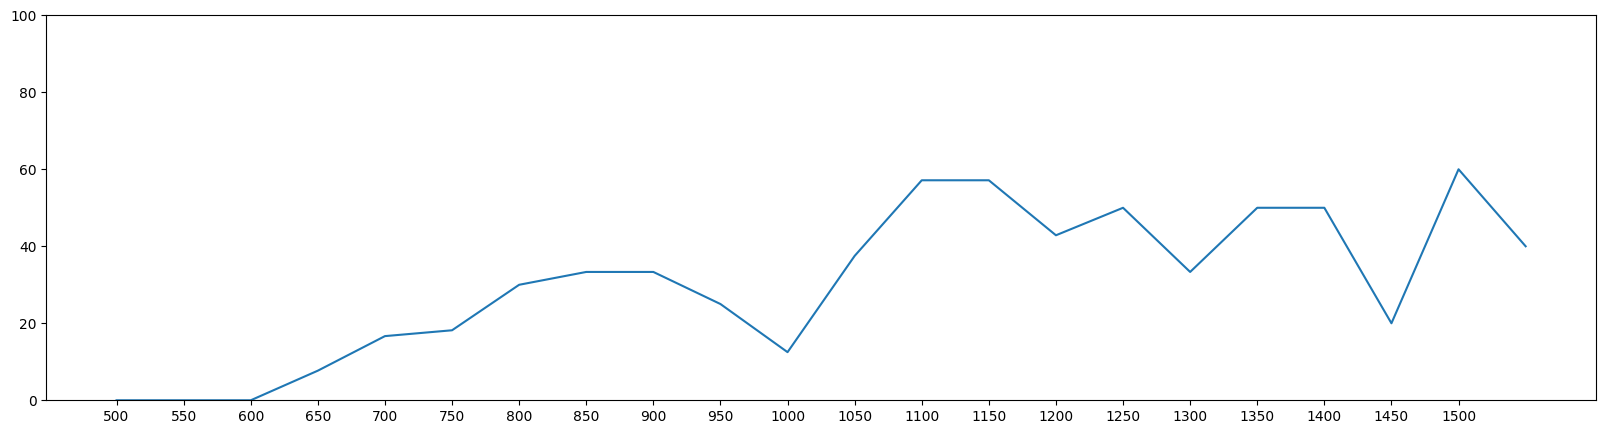

In [ ]:
plt.figure(figsize=(20,5))
plt.ylim([0,100])
plt.xticks(np.arange(500, 1550, 50))
plt.plot(x,y)